In [1]:
# Based on docs:
# https://docs.lightly.ai/self-supervised-learning/tutorials/package/tutorial_simclr_clothing.html

# Also, see:
# https://github.com/giakoumoglou/classification/blob/main/notebooks/main_simclr.ipynb
# https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_digits.html

## Imports

In [37]:
import os
import random
import shutil

import matplotlib.pyplot as plt
import numpy as np
import pytorch_lightning as pl
import torch
import torch.nn as nn
import torchvision
import torchvision.datasets as datasets
from PIL import Image

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import normalize

from lightly.data import LightlyDataset
from lightly.transforms import SimCLRTransform, utils

## Configuration

We set some configuration parameters for our experiment.
Feel free to change them and analyze the effect.

The default configuration with a batch size of 256 and input resolution of 128
requires 6GB of GPU memory.



In [14]:
num_workers = 8
batch_size = 256
seed = 1
max_epochs = 20
input_size = 128
num_ftrs = 32

Let's set the seed for our experiments



In [15]:
pl.seed_everything(seed)

Seed set to 1


1

In [18]:
# Create the directory if it doesn't exist
os.makedirs("./datasets/mnist", exist_ok=True)
os.makedirs("./datasets/mnist/train", exist_ok=True)
os.makedirs("./datasets/mnist/test", exist_ok=True)

In [ ]:
# Download the MNIST dataset
train_dataset = datasets.MNIST(root="./datasets/mnist", train=True, download=True)
test_dataset = datasets.MNIST(root="./datasets/mnist", train=False, download=True)

In [ ]:
# Save the images to the directory
for i, (image, label) in enumerate(train_dataset):
    image.save(f"./datasets/mnist/train/{i}.png")

for i, (image, label) in enumerate(test_dataset):
    image.save(f"./datasets/mnist/test/{i}.png")

In [19]:
# Remove original data to prevent errors
shutil.rmtree("./datasets/mnist/MNIST")

In [17]:
path_to_data = r"./datasets/mnist"

## Setup data augmentations and loaders

The images from the dataset have been taken from above when the clothing was
on a table, bed or floor. Therefore, we can make use of additional augmentations
such as vertical flip or random rotation (90 degrees).
By adding these augmentations we learn our model invariance regarding the
orientation of the clothing piece. E.g. we don't care if a shirt is upside down
but more about the strcture which make it a shirt.

You can learn more about the different augmentations and learned invariances
here: `lightly-advanced`.



In [18]:
transform = SimCLRTransform(input_size=input_size, vf_prob=0.5, rr_prob=0.5)

# We create a torchvision transformation for embedding the dataset after
# training
test_transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.Resize((input_size, input_size)),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(
            mean=utils.IMAGENET_NORMALIZE["mean"],
            std=utils.IMAGENET_NORMALIZE["std"],
        ),
    ]
)

dataset_train_simclr = LightlyDataset(input_dir=path_to_data, transform=transform)

dataset_test = LightlyDataset(input_dir=path_to_data, transform=test_transform)

dataloader_train_simclr = torch.utils.data.DataLoader(
    dataset_train_simclr,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True,
    num_workers=num_workers,
)

dataloader_test = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers,
)

## Create the SimCLR Model
Now we create the SimCLR model. We implement it as a PyTorch Lightning Module
and use a ResNet-18 backbone from Torchvision. Lightly provides implementations
of the SimCLR projection head and loss function in the `SimCLRProjectionHead`
and `NTXentLoss` classes. We can simply import them and combine the building
blocks in the module.



In [8]:
from lightly.loss import NTXentLoss
from lightly.models.modules.heads import SimCLRProjectionHead


class SimCLRModel(pl.LightningModule):
    def __init__(self):
        super().__init__()

        # create a ResNet backbone and remove the classification head
        resnet = torchvision.models.resnet18()
        self.backbone = nn.Sequential(*list(resnet.children())[:-1])

        hidden_dim = resnet.fc.in_features
        self.projection_head = SimCLRProjectionHead(hidden_dim, hidden_dim, 128)

        self.criterion = NTXentLoss()

    def forward(self, x):
        h = self.backbone(x).flatten(start_dim=1)
        z = self.projection_head(h)
        return z

    def training_step(self, batch, batch_idx):
        (x0, x1), _, _ = batch
        z0 = self.forward(x0)
        z1 = self.forward(x1)
        loss = self.criterion(z0, z1)
        self.log("train_loss_ssl", loss)
        return loss

    def configure_optimizers(self):
        optim = torch.optim.SGD(
            self.parameters(), lr=6e-2, momentum=0.9, weight_decay=5e-4
        )
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, max_epochs)
        return [optim], [scheduler]

Train the module using the PyTorch Lightning Trainer on a single GPU.



In [22]:
# Uncomment for training (may take some time)

# model = SimCLRModel()
# trainer = pl.Trainer(max_epochs=max_epochs, devices=1, accelerator="gpu")
# trainer.fit(model, dataloader_train_simclr)

# TODO: add early stopping, as the model doesn't improve further after around 10 epochs

Next we create a helper function to generate embeddings
from our test images using the model we just trained.
Note that only the backbone is needed to generate embeddings,
the projection head is only required for the training.
Make sure to put the model into eval mode for this part!



In [19]:
def generate_embeddings(model, dataloader):
    """Generates representations for all images in the dataloader with
    the given model
    """

    embeddings = []
    filenames = []
    with torch.no_grad():
        for img, _, fnames in dataloader:
            img = img.to(model.device)
            emb = model.backbone(img).flatten(start_dim=1)
            embeddings.append(emb)
            filenames.extend(fnames)

    embeddings = torch.cat(embeddings, 0)
    embeddings = normalize(embeddings.to("cpu"))
    return embeddings, filenames

In [20]:
# For eval only
model = SimCLRModel.load_from_checkpoint(
    "./lightning_logs/version_4/checkpoints/epoch=14-step=4095.ckpt"
)

In [21]:
model.eval()
embeddings, filenames = generate_embeddings(model, dataloader_test)

## Visualize Nearest Neighbors
Let's look at the trained embedding and visualize the nearest neighbors for
a few random samples.

We create some helper functions to simplify the work



In [23]:
def get_image_as_np_array(filename: str):
    """Returns an image as an numpy array"""
    img = Image.open(filename)
    return np.asarray(img)

In [24]:
def plot_knn_examples(embeddings, filenames, n_neighbors=3, num_examples=6):
    """Plots multiple rows of random images with their nearest neighbors"""
    # lets look at the nearest neighbors for some samples
    # we use the sklearn library
    nbrs = NearestNeighbors(n_neighbors=n_neighbors).fit(embeddings)
    distances, indices = nbrs.kneighbors(embeddings)

    # get 5 random samples
    samples_idx = np.random.choice(len(indices), size=num_examples, replace=False)

    # loop through our randomly picked samples
    for idx in samples_idx:
        fig = plt.figure()
        # loop through their nearest neighbors
        for plot_x_offset, neighbor_idx in enumerate(indices[idx]):
            # add the subplot
            ax = fig.add_subplot(1, len(indices[idx]), plot_x_offset + 1)
            # get the correponding filename for the current index
            fname = os.path.join(path_to_data, filenames[neighbor_idx])
            # plot the image
            plt.imshow(get_image_as_np_array(fname))
            # set the title to the distance of the neighbor
            ax.set_title(f"d={distances[idx][plot_x_offset]:.3f}")
            # let's disable the axis
            plt.axis("off")

d:\__repos\ml_concepts\venv\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] Nie można odnaleźć określonego pliku
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "d:\__repos\ml_concepts\venv\lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
  File "C:\Users\Maciek\AppData\Local\Programs\Python\Python310\lib\subprocess.py", line 501, in run
    with Popen(*popenargs, **kwargs) as process:
  File "C:\Users\Maciek\AppData\Local\Programs\Python\Python310\lib\subprocess.py", line 966, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\Maciek\AppData\Local\Programs\Python\Python310\lib\subprocess.py", line 1435, in _execute_child
    hp, ht, pid

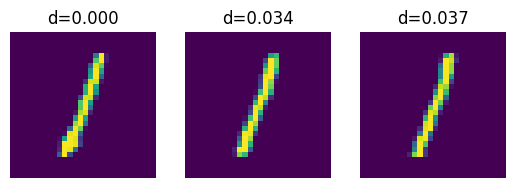

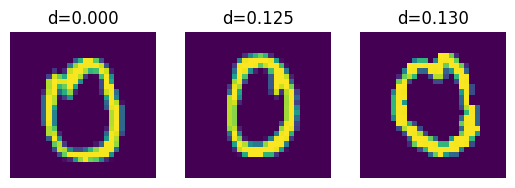

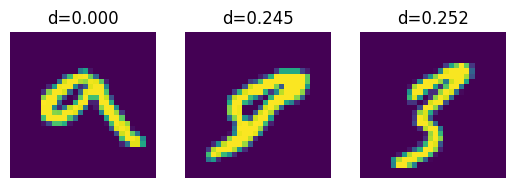

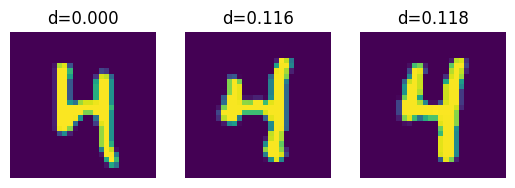

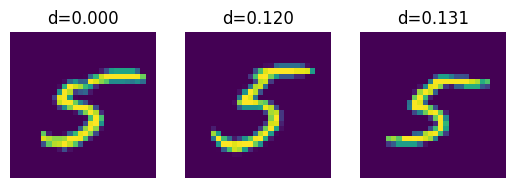

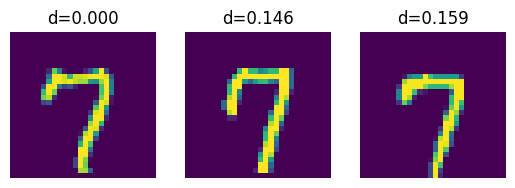

In [25]:
plot_knn_examples(embeddings, filenames)

## Clusters
Let's look at the trained embedding and visualize clusters in latent space.

In [47]:
def plot_clusters(embeddings, filenames, n_clusters=10, num_examples=10):
    """Plots multiple rows of random images with their cluster centroids"""
    # apply k-means clustering
    reduced_embeddings = PCA(n_components=2).fit_transform(embeddings)

    kmeans = KMeans(n_clusters=n_clusters)
    labels = kmeans.fit_predict(reduced_embeddings)
    centroids = kmeans.cluster_centers_

    print(f"Cluster centroids: {centroids}")
    print(f"Cluster sizes: {np.bincount(labels)}")

    filenames_to_print = random.sample(filenames, 30)
    # filenames_to_print = random.sample(filenames, int(len(filenames)//1000))
    plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=labels)
    # for i, filename in enumerate(filenames_to_print):
    #     plt.annotate(filename, (reduced_embeddings[i, 0], reduced_embeddings[i, 1]))

    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.title("Cluster Plot")
    plt.show()

Cluster centroids: [[ 0.28438886 -0.2014426 ]
 [-0.26913696  0.12039405]
 [ 0.00548434  0.13852677]
 [ 0.25960765  0.19456109]
 [ 0.36262978  0.00979465]
 [-0.16427566 -0.17247853]
 [ 0.08689006 -0.31125934]
 [ 0.09774469 -0.0580082 ]
 [-0.3586269  -0.09968775]
 [-0.02359972  0.36668652]]
Cluster sizes: [ 5876  6223  7069  5435  6000  4487  7611  7547 11398  8354]


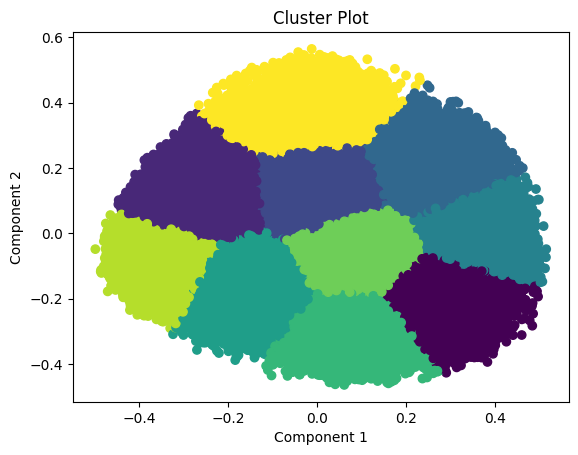

In [48]:
plot_clusters(embeddings, filenames)